# PROJET 6 - CLASSIFICATION
***

In [3]:
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import cv2

from PIL import Image, ImageEnhance

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from skimage import io, color

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

2024-08-07 22:45:57.758417: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 22:45:57.773765: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 22:45:57.778474: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 22:45:57.790141: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-07 22:45:58.463830: W tensorflow/compiler/tf2

In [4]:
#on importe nos données
data = pd.read_csv('data/data_classification', sep = ',')

data.head()

,uniq_id,product_name,main_category,image,mce
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,4
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,0
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,0
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,4
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,4


## 1 - Data Augmentation
***

In [5]:
Image.MAX_IMAGE_PIXELS = None

In [6]:
normal_pics_path = "data/images/pictures_bis/normal"

In [4]:
#on va transformer nos images (rotation, contraste, zoom)

def rotation(input_folder, output_folder, angle):

    #on cree le dossier de sortie s'il n'existe pas
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for pic in os.listdir(input_folder):
        pic_path = os.path.join(input_folder, pic)

        #on ouvre l'image
        img = Image.open(pic_path)

        #on effectue la rotation
        rotated_img = img.rotate(angle=angle, expand = True)

        #on sauvegarde
        base_name, ext = os.path.splitext(pic)
        output_pic = f"{base_name}_rotate_{angle}{ext}"
        output_path = os.path.join(output_folder, output_pic)
        rotated_img.save(output_path)

In [5]:
def zooming(input_folder, output_folder, factor_percents):

    #on cree le dossier de sortie s'il n'existe pas
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for pic in os.listdir(input_folder):
        pic_path = os.path.join(input_folder, pic)

        #on ouvre l'image
        img = Image.open(pic_path)
        width, height = img.size

        #on recupere les nouvelles dimensions
        new_width = int(width * (1 - (factor_percents / 100)))
        new_height = int(height * (1 - (factor_percents / 100)))

        #on définit les coordonnées du cadre à récuperer
        left_corner = (width - new_width) // 2
        top_corner = (height - new_height) // 2
        right_corner = left_corner + new_width
        bottom_corner = top_corner + new_height

        #on découpe la région centrale
        cropped_pic = img.crop((left_corner, top_corner, right_corner, bottom_corner))

        #on redimensionne cette partie aux dimensions originales de l'image
        zoomed_img = cropped_pic.resize((width, height), Image.LANCZOS)

        #on sauvegarde
        base_name, ext = os.path.splitext(pic)
        output_pic = f"{base_name}_zoomed_{factor_percents}{ext}"
        output_path = os.path.join(output_folder, output_pic)
        zoomed_img.save(output_path)

In [6]:
def contrasting(input_folder, output_folder, factor_percents):

    factor = factor_percents / 100
    
    #on cree le dossier de sortie s'il n'existe pas
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for pic in os.listdir(input_folder):
        pic_path = os.path.join(input_folder, pic)

        #on ouvre l'image
        img = Image.open(pic_path)

        #on ajuste le contraste
        enhancer = ImageEnhance.Contrast(img)
        contrasted_img = enhancer.enhance(factor)

        #on sauvegarde
        base_name, ext = os.path.splitext(pic)
        output_pic = f"{base_name}_contrasted_{factor_percents}{ext}"
        output_path = os.path.join(output_folder, output_pic)
        contrasted_img.save(output_path)

In [7]:
#on cree le dossier de sortie

cnn_pics_path = 'data/images/cnn_pics'

In [31]:
#on effectue les rotations de 90, 180 et 270 degrés

rotation(normal_pics_path, cnn_pics_path, 90)
rotation(normal_pics_path, cnn_pics_path, 180)
rotation(normal_pics_path, cnn_pics_path, 270)

In [32]:
#on effectue les zooms de 15, 30 et 45%

zooming(normal_pics_path, cnn_pics_path, 15)
zooming(normal_pics_path, cnn_pics_path, 30)
zooming(normal_pics_path, cnn_pics_path, 45)

In [33]:
#on effectue les contrastes de 0.75, 1, 1.25 et 1.50

contrasting(normal_pics_path, cnn_pics_path, 75)
contrasting(normal_pics_path, cnn_pics_path, 100)
contrasting(normal_pics_path, cnn_pics_path, 125)
contrasting(normal_pics_path, cnn_pics_path, 150)

## 2 - CNN Transfert Learning
***

In [8]:
#on cree une liste contenant tous les chemins des images
pic_paths_list = []

for root, dirs, files in os.walk('data/images/cnn_pics'):
    for file in files:
        pic_path = os.path.join(root, file)
        pic_paths_list.append(pic_path)

In [9]:
#on redimensionne nos images et on les mets en nuances de gris

for pic_path in pic_paths_list:
    
    #On récupère l'image
    img = Image.open(pic_path)
    
    #On la redimensionne
    resized_img = img.resize((256,256))
    
    #On la passe en niveaux de gris
    gray_img = resized_img.convert('L')
    
    #On la sauvegarde
    gray_img.save(pic_path)

In [9]:
#on cree une fonction pour preprocess les images

def preprocessing_pic(pic_path):
        
    img = load_img(pic_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)

    return img_preprocessed

In [10]:
#on définit notre modèle de base sans la derniere couche pour extraire les features des images

model = VGG16(weights = 'imagenet', include_top = False)
features_extractor = Model(inputs = model.inputs, outputs = model.layers[-1].output)

I0000 00:00:1723063597.167315    4746 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723063597.556704    4746 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723063597.556929    4746 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723063597.558877    4746 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [11]:
#on preprocess nos images et on sort les features

pictures_features = []

for pic_path in pic_paths_list:
    picture = preprocessing_pic(pic_path)
    features = features_extractor.predict(picture, verbose = 0)[0]

    pictures_features.append(features)

I0000 00:00:1723063605.997910   93875 service.cc:146] XLA service 0x7dfb3c005170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723063605.997952   93875 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-08-07 22:46:46.010138: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-07 22:46:46.112387: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
I0000 00:00:1723063606.623093   93875 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [12]:
#on passe en array
pictures_features_array = np.asarray(pictures_features)

In [13]:
pictures_features_array.shape

(10500, 7, 7, 512)

In [14]:
#on cree la liste des labels

pictures_labels = []

for path in pic_paths_list:
    path_uniq_id = os.path.basename(path).split('_')[0]

    if path_uniq_id in data['uniq_id'].values:
        mce_value = data.loc[data['uniq_id'] == path_uniq_id, 'mce'].values[0]

        pictures_labels.append(mce_value)

In [15]:
#on peut séparer les données en jeux d'entrainement et de test

X = pictures_features_array
y = pictures_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [16]:
#on les aplatit

X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

In [17]:
#on instancie notre classifieur puis on fit

rfc = RandomForestClassifier()
rfc.fit(X_train_flattened, y_train)

RandomForestClassifier()

In [18]:
#on predit sur les données de test

y_pred = rfc.predict(X_test_flattened)

------------------------------------------------------------
Résultats
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.84      0.87       312
           1       0.92      0.88      0.90       299
           2       0.88      0.92      0.90       309
           3       0.86      0.90      0.88       294
           4       0.83      0.89      0.86       274
           5       0.93      0.90      0.92       306
           6       0.99      0.96      0.98       306

    accuracy                           0.90      2100
   macro avg       0.90      0.90      0.90      2100
weighted avg       0.90      0.90      0.90      2100

------------------------------------------------------------
Score de précision : 0.9
------------------------------------------------------------


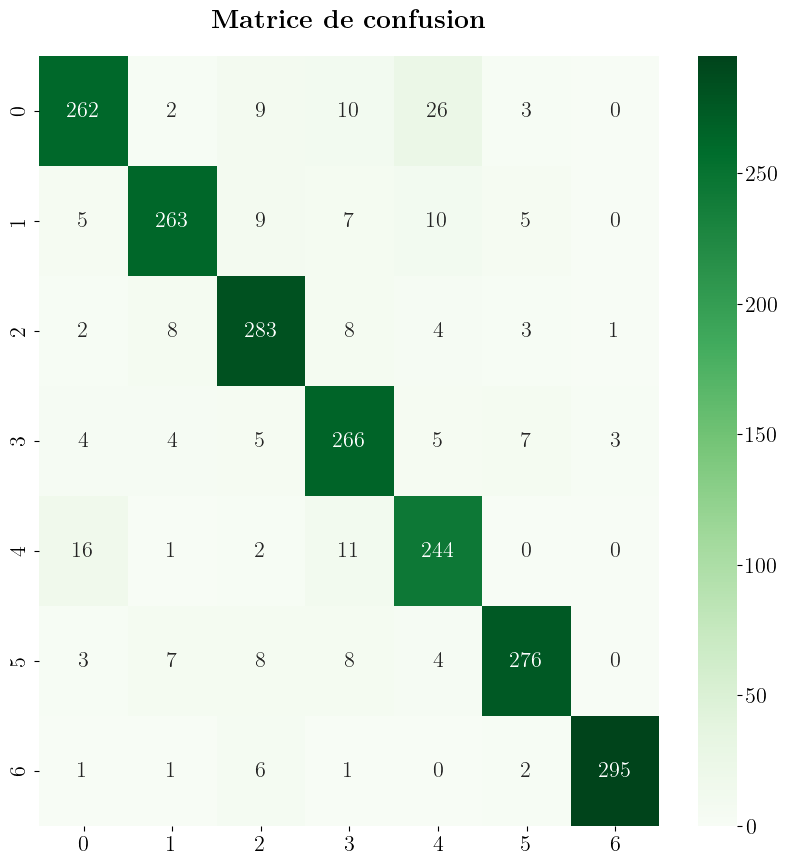

In [19]:
#On peut mesurer les scores

accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

print('-' * 60)
print("Résultats")
print('-' * 60)
print(classification_report(y_test, y_pred))
print('-' * 60)
print("Score de précision :", round(accuracy,2))
print("-" * 60)
#on plot la matrice
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', size = 16)

plt.figure(figsize = (10,10))
sns.heatmap(conf_mat, annot = True, cmap = 'Greens', fmt = 'd')
plt.title(f"\\textbf{{Matrice de confusion}}", pad = 20)
plt.show()

In [20]:
#On recupere les classes originales du labelencoder utilisé dans l'autre notebook

categories = []
code_values = []

for cat in data['main_category'].unique().tolist():
    categories.append(cat)
    mce = int(data.loc[data['main_category'] == cat, 'mce'].mean())
    code_values.append(mce)

#on cree un dictionnaire
categories_zipped = sorted(zip(code_values, categories))
categories_dict = {value: category for value, category in categories_zipped}

In [21]:
#on cree les vecteurs y_test et y_pred avec les catégories textuelles

y_test_decoded = [categories_dict[i] for i in y_test]
y_pred_decoded = [categories_dict[i] for i in y_pred]

In [36]:
#on raccourcit certains titres de catégories pour la taille du graphique et sa lisibilité

shorten_categories = [category for category in categories_dict.values()]

shorten_categories[1] = 'Beauty'
shorten_categories[3] = 'Home Decor'
shorten_categories[4] = 'Furnishing'
shorten_categories[5] = 'Kitchen'

In [37]:
shorten_categories

['Baby Care',
 'Beauty',
 'Computers',
 'Home Decor',
 'Furnishing',
 'Kitchen',
 'Watches']

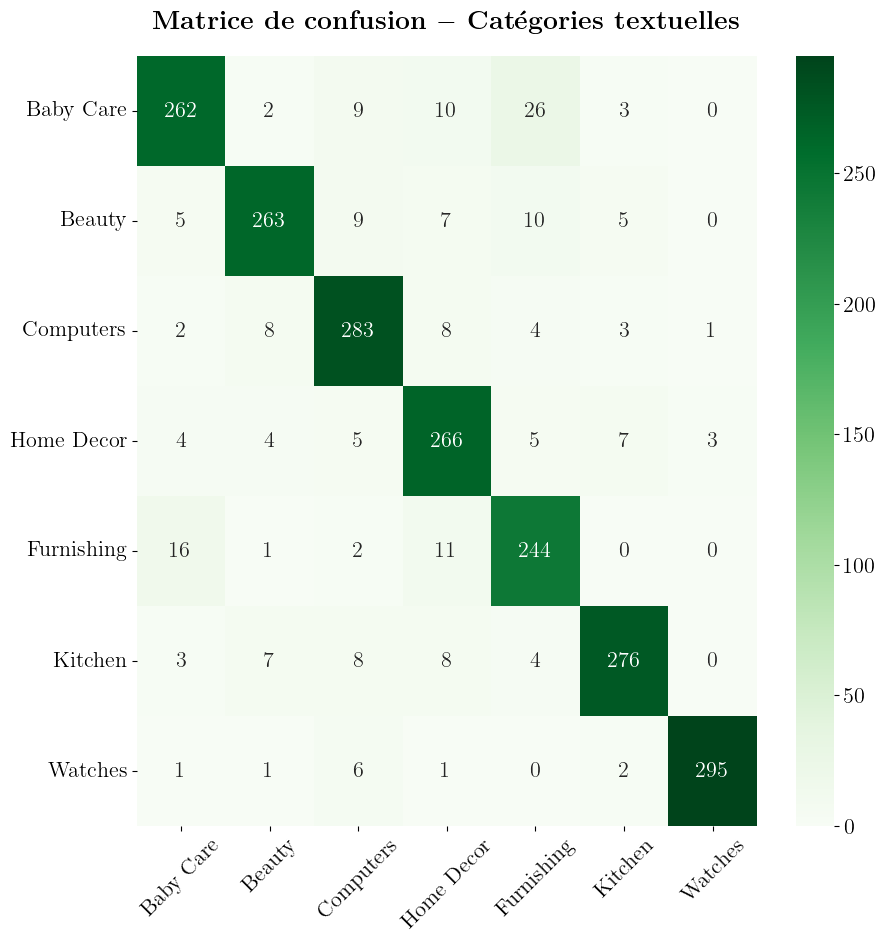

In [44]:
#on peut afficher la matrice de confusion avec les vraies catégories

conf_mat_decoded = confusion_matrix(y_test_decoded, y_pred_decoded)
conf_mat_decoded_df = pd.DataFrame(conf_mat_decoded, index = shorten_categories, columns = shorten_categories)

plt.figure(figsize = (10,10))
sns.heatmap(conf_mat_decoded_df, annot = True, cmap = 'Greens', fmt = 'd', xticklabels = conf_mat_decoded_df.index, yticklabels = conf_mat_decoded_df.columns)
plt.title(f"\\textbf{{Matrice de confusion $-$ Catégories textuelles}}", pad = 20)
plt.xticks(rotation = 45)
plt.savefig(f"./graphics/conf_mat_classification.pdf", bbox_inches='tight')
plt.show()